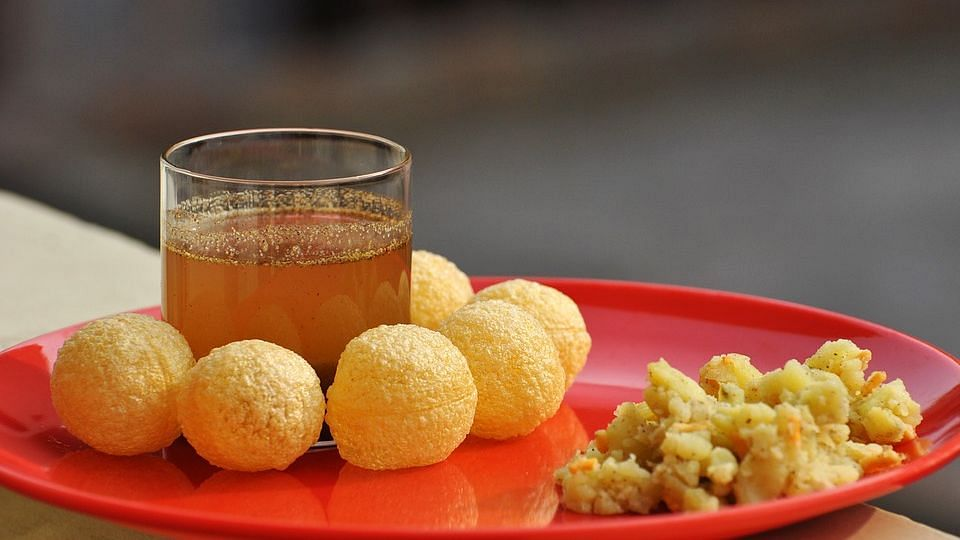

In [13]:
from PIL import Image
import requests

url = 'https://huggingface.co/rajistics/finetuned-indian-food/resolve/main/126.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [1]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "./food_classification"

feature_extractor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

2024-07-24 16:17:46.180751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 16:17:46.307333: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 16:17:46.811383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/shagun/miniconda3/envs/tf/lib/
2024-07-24 16:17:46.811460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

In [25]:
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [26]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [27]:
predicted_class_idx = logits.argmax(-1).item()
predicted_class = model.config.id2label[predicted_class_idx]
print("Predicted class:", predicted_class)

Predicted class: Baked Potato


In [2]:
from datasets import load_dataset
ds = load_dataset("imagefolder", data_dir = './Test')
ds = ds['train']
ds

Resolving data files:   0%|          | 0/2779 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 2777
})

In [3]:
tick_labels = ds.features['label'].names
n_classes = len(tick_labels)
tick_labels

['baked_potato',
 'burger',
 'butter_naan',
 'chai',
 'chapati',
 'chole_bhature',
 'crispy_chicken',
 'dal_makhani',
 'dhokla',
 'donut',
 'fried_rice',
 'fries',
 'hot_dog',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'momos',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'pizza',
 'samosa',
 'sandwich',
 'taco',
 'taquito']

In [4]:
from sklearn.metrics import *
import seaborn as sns
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt

def showClassificationReport(ds, feature_extractor, model):
    y_pred, y_true = [], []
    for i in range(ds.num_rows):
        image = ds[i]['image']
        encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
        with torch.no_grad():
            outputs = model(**encoding)
            logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()
        y_pred.append(model.config.id2label[predicted_class_idx])
        y_true.append(tick_labels[ds[i]['label']])
    fig, ax = plt.subplots(figsize=(20,20))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=tick_labels)
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=tick_labels, target_names=tick_labels))

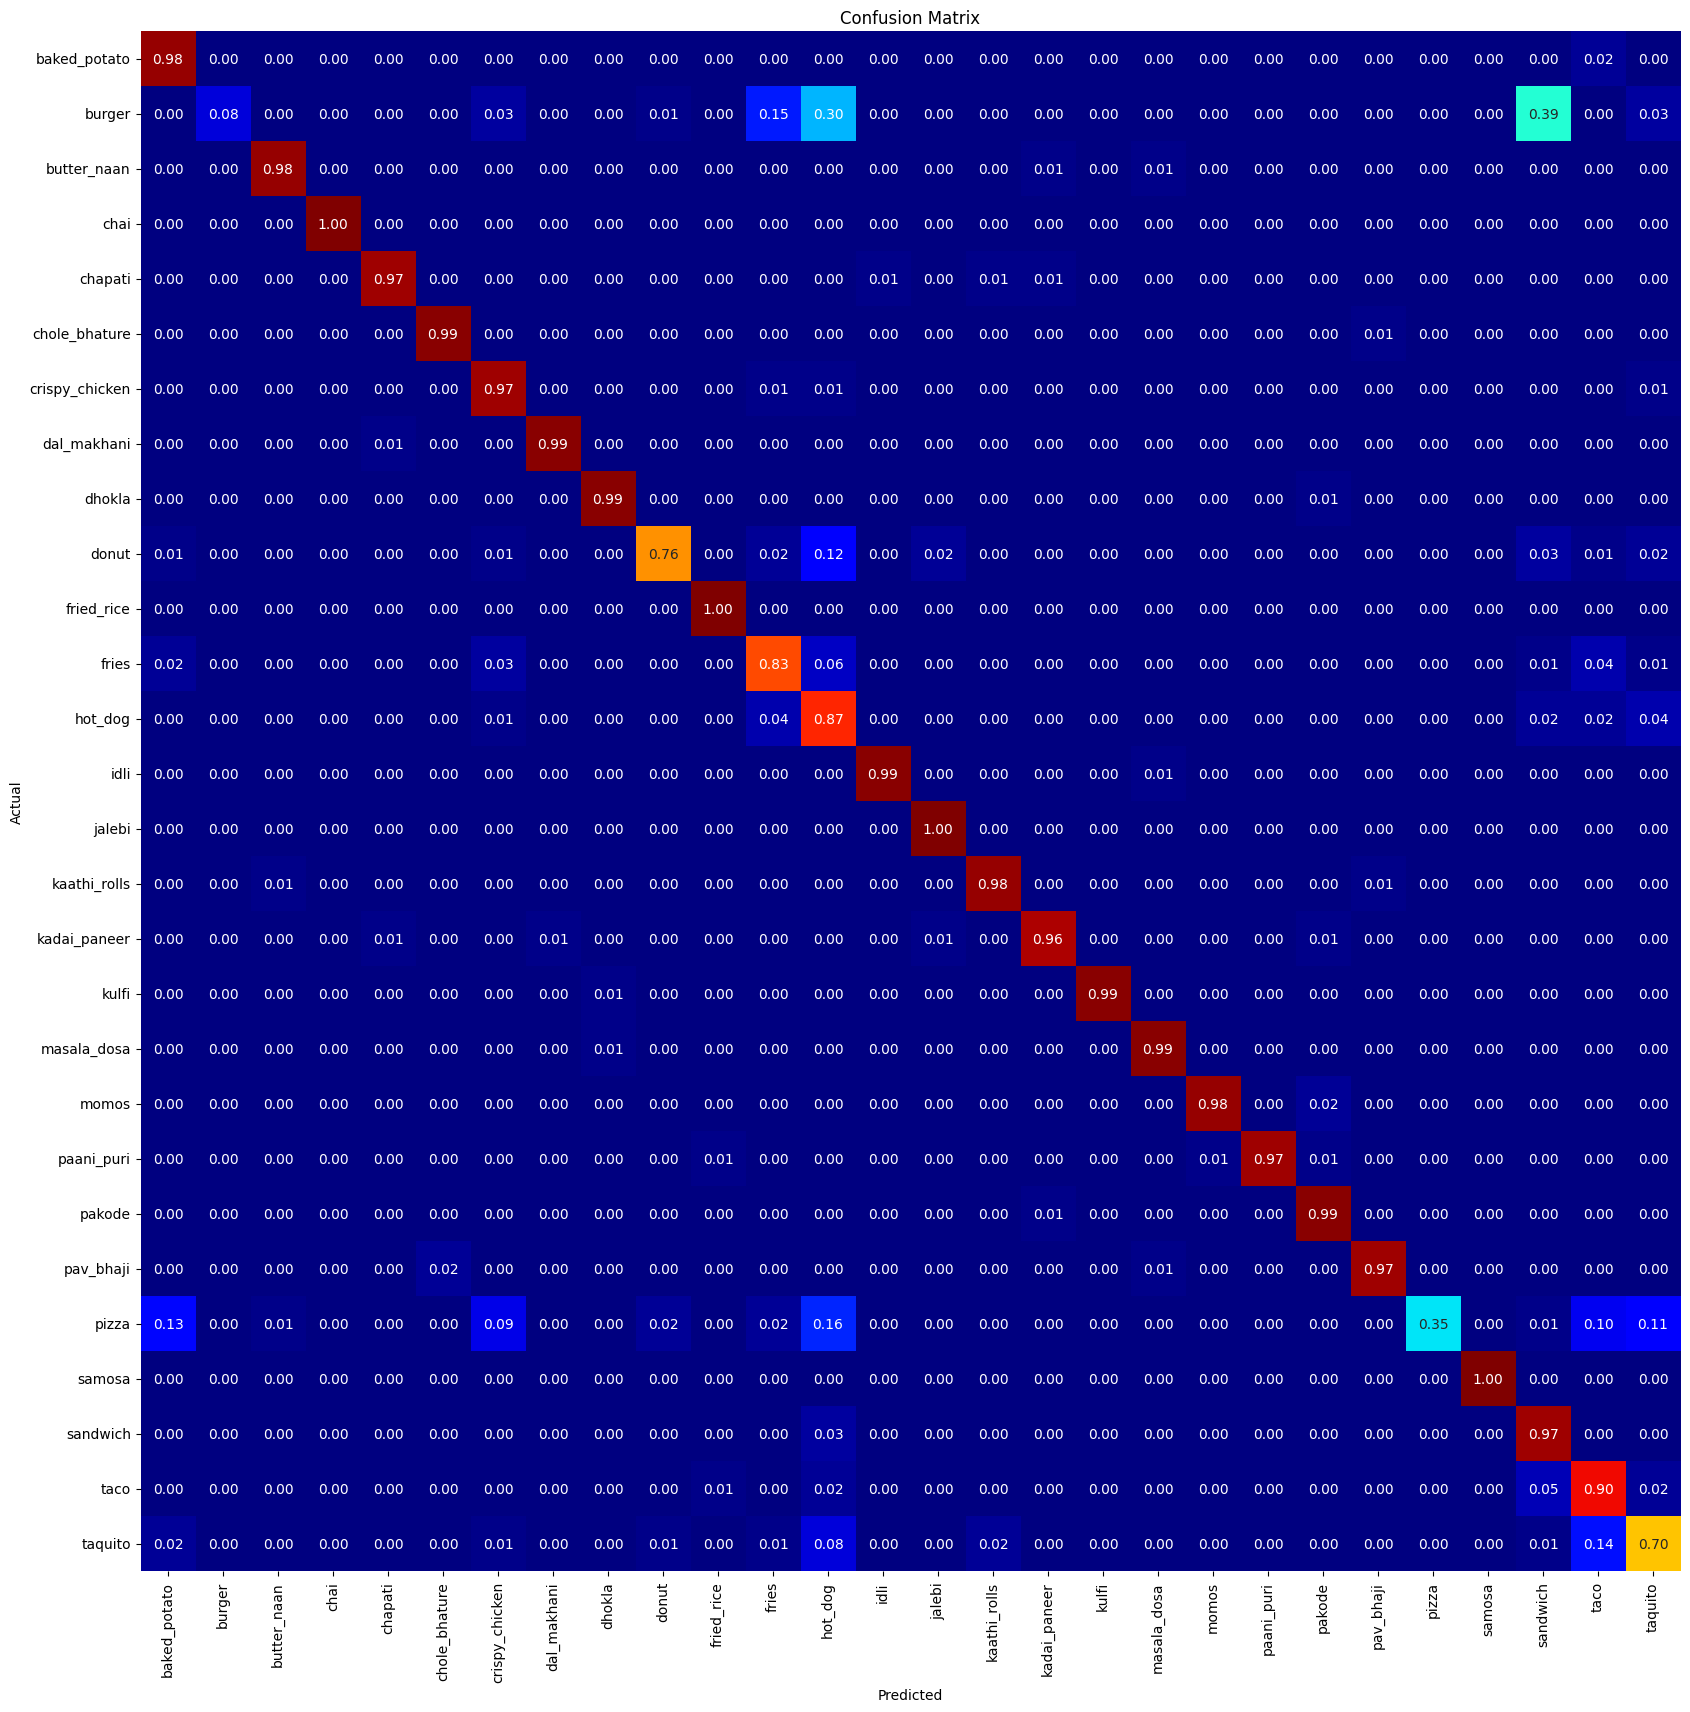

Classification Report:
                precision    recall  f1-score   support

  baked_potato       0.84      0.98      0.91       100
        burger       1.00      0.08      0.15        99
   butter_naan       0.98      0.98      0.98        99
          chai       1.00      1.00      1.00        99
       chapati       0.98      0.97      0.97        99
 chole_bhature       0.98      0.99      0.98        99
crispy_chicken       0.84      0.97      0.90       100
   dal_makhani       0.99      0.99      0.99        99
        dhokla       0.98      0.99      0.98        99
         donut       0.95      0.76      0.84        99
    fried_rice       0.98      1.00      0.99        99
         fries       0.77      0.83      0.80       100
       hot_dog       0.52      0.87      0.65        99
          idli       0.99      0.99      0.99        98
        jalebi       0.97      1.00      0.99       100
  kaathi_rolls       0.97      0.98      0.97        99
  kadai_paneer       0.9

In [5]:
showClassificationReport(ds, feature_extractor, model)